# Análise preditiva do Programa Mais Médicos

In [138]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Análise preditiva para desfecho categórico (churn)

### Carregamento dos dados

In [139]:
df = pd.read_csv('C:\\Users\\Lapei_Cigets\\Documents\\GitHub\\sa_maismedicos\\01_dados\\dados resultantes\\df_modelagem.csv')

df = df.drop(["Unnamed: 0",
              "meses_no_local_alocado",
              "var_taxa_ocupacao"], 
             axis='columns')

df[['m_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro', 'm_dentista']] = df[['m_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro', 'm_dentista']].fillna(0)
df['churn'] = df['churn'].map({'permanece': 0, 'migrou': 1})

In [140]:
df.head()

,churn,idade,atuacao_previa_no_municipio,anos_atuacao_previa_no_municipio,media_vinculos_mes,Prorrogado,m_agente_saude,m_tec_aux_enf,m_enfermeiro,m_dentista,...,variacao_pib,pop_ocupada_2019,orcamento_saude,esgotamento_sanitario,taxa_homicidio,ideb_anosfinais,investimento_infraestrutura,equipamentos_esportivos,equipamentos_culturais,distancia_capital
0,0,35,Não,0.0,2.348485,NÃO,9.473684,8.513158,4.815789,0.000000,...,66,10435,366.57,0.0,33.946,4.3,103.676,5.703,9.125,636.0
1,1,30,Não,0.0,1.000000,NÃO,13.375000,1.000000,1.625000,1.000000,...,61,2506,683.09,0.0,64.522,4.7,5021.768,18.540,4.635,114.0
2,0,75,Não,0.0,1.000000,SIM,9.447761,3.585821,1.902985,1.343284,...,120,2199,626.30,0.0,37.161,4.6,3097.942,0.000,4.144,147.0
3,1,37,Não,0.0,1.000000,NÃO,7.771429,1.000000,1.000000,0.000000,...,111,1230,457.94,0.0,19.552,5.3,3190.453,2.464,4.928,155.0
4,1,62,Não,0.0,1.000000,SIM,5.318182,2.000000,1.000000,1.000000,...,109,3646,614.94,0.0,24.491,4.0,4048.908,12.291,4.097,158.0


### Pré-processamento

In [141]:
y = df['churn']  
X = df.drop(columns=['churn']) 

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


## Dividindo em treino e teste

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Instanciando modelos e rodando modelos

In [143]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier()
}

param_grids = {
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'classifier__max_depth': [3, 5, 10]},
    'Random Forest': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 5, 10],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__subsample': [0.7, 0.85, 1.0],
        'classifier__colsample_bytree': [0.7, 0.85, 1.0],
        'classifier__gamma': [0, 0.1, 0.5]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [20, 31, 40],
        'classifier__min_child_samples': [10, 20, 30]
    }
}

# Validação cruzada e otimização de hiperparâmetros
best_models = {}

for name, model in models.items():
    print(f"Treinando modelo: {name}")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    param_grid = param_grids.get(name, {})
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    print(f"Melhores parâmetros para {name}: {grid_search.best_params_}\n")

# Avaliação final no conjunto de teste
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

Treinando modelo: Logistic Regression
Melhores parâmetros para Logistic Regression: {'classifier__C': 0.01}

Treinando modelo: Decision Tree
Melhores parâmetros para Decision Tree: {'classifier__max_depth': 3}

Treinando modelo: Random Forest
Melhores parâmetros para Random Forest: {'classifier__max_depth': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

Treinando modelo: XGBoost


c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores parâmetros para XGBoost: {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.5, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.7}

Treinando modelo: LightGBM
[LightGBM] [Info] Number of positive: 904, number of negative: 264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3896
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,773973 -> initscore=1,230880
[LightGBM] [Info] Start training from score 1,230880
Melhores parâmetros para LightGBM: {'classifier__learning_rate': 0.01, 'classifier__min_child_samples': 10, 'classifier__n_estimators': 100, 'classifier__num_leaves': 20}



In [144]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='ROC AUC', ascending=False))

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.780822   0.795620  0.964602  0.872000  0.824685
4             LightGBM  0.787671   0.797101  0.973451  0.876494  0.819020
2        Random Forest  0.780822   0.781250  0.995575  0.875486  0.817914
3              XGBoost  0.773973   0.773973  1.000000  0.872587  0.813791
1        Decision Tree  0.767123   0.834746  0.871681  0.852814  0.800047


In [145]:
best_model_name = results_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']
best_model = best_models[best_model_name]


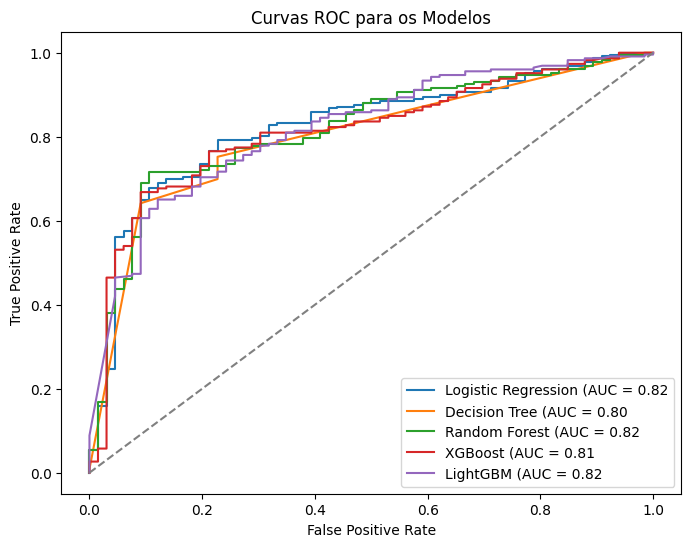

In [162]:
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC para os Modelos')
plt.legend()
plt.show()

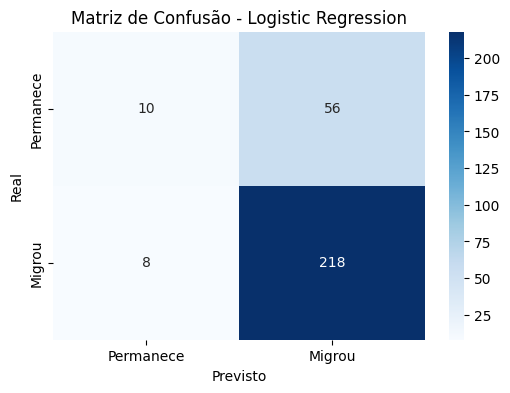

In [163]:
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Permanece', 'Migrou'], yticklabels=['Permanece', 'Migrou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.show()


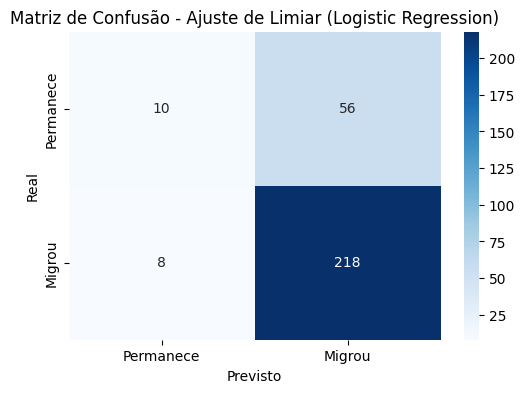

In [164]:
from sklearn.metrics import precision_recall_curve

# Obter probabilidades do modelo
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Testar diferentes limiares
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_best)

best_threshold = 0.5 # Ajuste conforme necessário
y_pred_adjusted = (y_prob_best >= best_threshold).astype(int)

# Avaliar novamente a matriz de confusão
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Permanece', 'Migrou'], yticklabels=['Permanece', 'Migrou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()


In [165]:
print("ROC AUC: ", roc_auc_score(y_test, y_pred_adjusted))
print("Precision: ", precision_score(y_test, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test, y_pred_adjusted))
print("Recall: ", recall_score(y_test, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora")

ROC AUC:  0.558058460713328
Precision:  0.7956204379562044
Accuracy:  0.7808219178082192
Recall:  0.9646017699115044
F1 Score:  0.8764940239043825
Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora


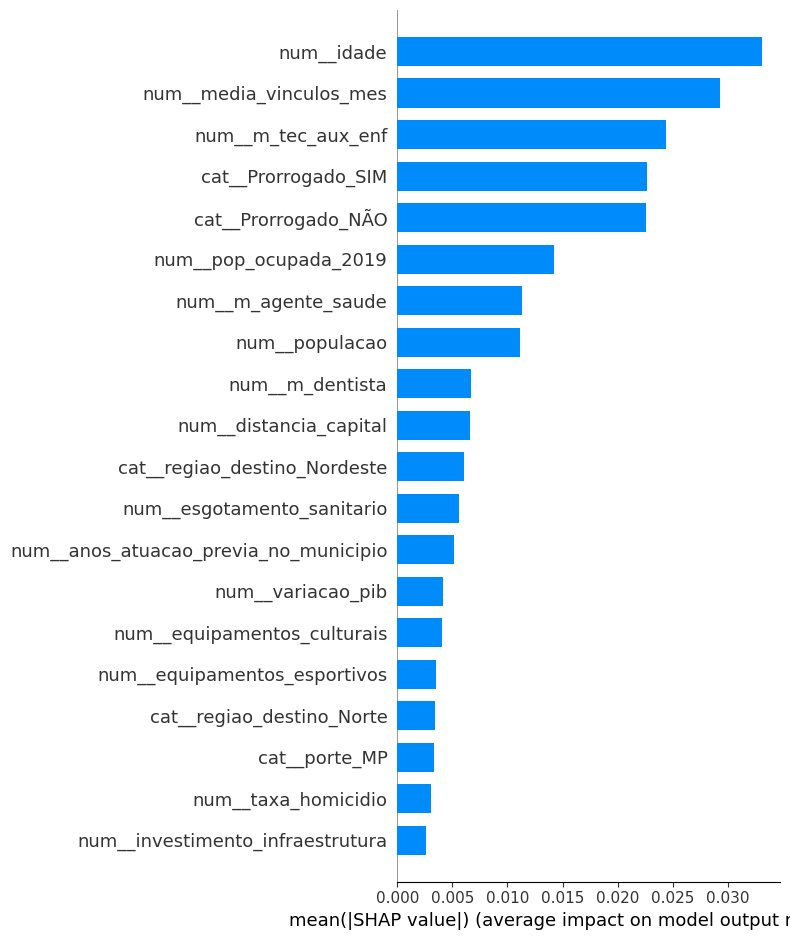

In [166]:
shap.summary_plot(shap_values, features=X_transformed, feature_names=X_transformed.columns, plot_type="bar")


PermutationExplainer explainer: 1461it [00:17, 34.98it/s]                          


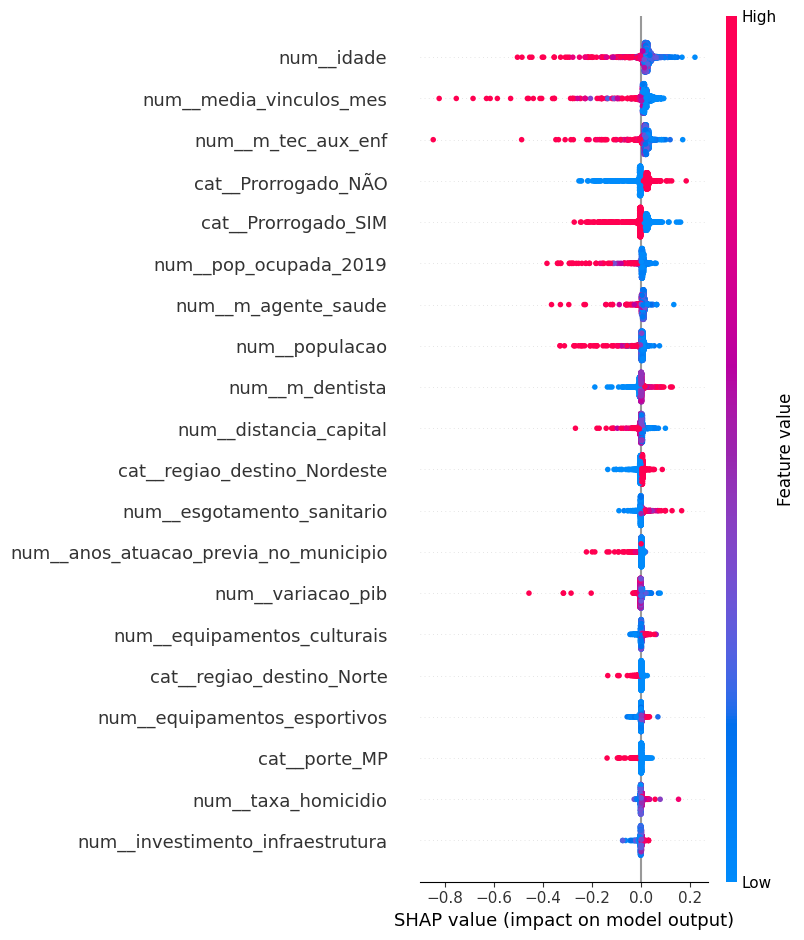

In [167]:
# Explicabilidade do modelo com SHAP
X_transformed = best_model.named_steps['preprocessor'].transform(X)

# Escolher o tipo correto de SHAP explainer dependendo do modelo
if isinstance(best_model.named_steps['classifier'], (xgb.XGBClassifier, lgb.LGBMClassifier, RandomForestClassifier, DecisionTreeClassifier)):
    explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
else:
    explainer = shap.Explainer(best_model.named_steps['classifier'].predict, X_transformed)

shap_values = explainer(X_transformed)

# Atribuir os nomes originais das colunas ao conjunto transformado
X_transformed = pd.DataFrame(X_transformed, columns=best_model.named_steps['preprocessor'].get_feature_names_out())

# Visualizar as principais features com nomes corretos
shap.summary_plot(shap_values, features=X_transformed, feature_names=X_transformed.columns)

O código abaixo é usado para treinar o modelo com a base completa

PermutationExplainer explainer: 1461it [00:20, 33.70it/s]                          


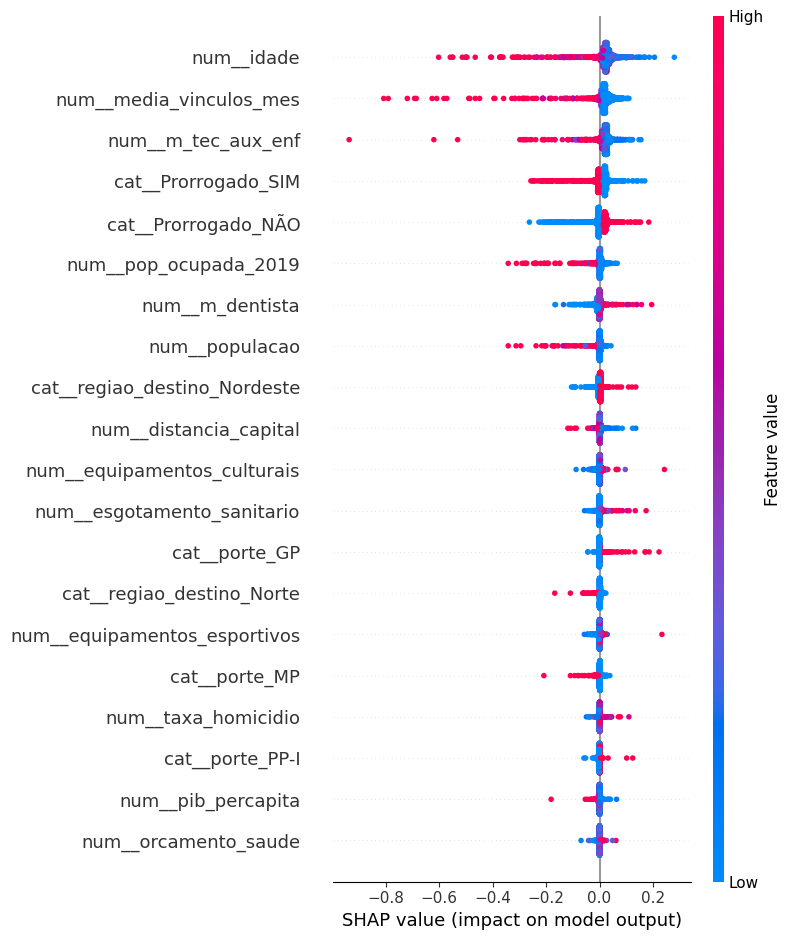

In [ ]:
# Re-treinar o melhor modelo com a base completa
best_model_name = results_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']
best_model = best_models[best_model_name]
best_model.fit(X, y)

# Explicabilidade do modelo com SHAP na base completa
X_transformed = best_model.named_steps['preprocessor'].transform(X)
explainer = shap.Explainer(best_model.named_steps['classifier'].predict, X_transformed)
shap_values = explainer(X_transformed)

# Atribuir os nomes originais das colunas ao conjunto transformado
X_transformed = pd.DataFrame(X_transformed, columns=best_model.named_steps['preprocessor'].get_feature_names_out())

# Visualizar as principais features
shap.summary_plot(shap_values, features=X_transformed, feature_names=X_transformed.columns)
shap.summary_plot(shap_values, features=X_transformed, feature_names=X_transformed.columns, plot_type="bar")



# Problema de regressão 